Copyright &copy; 2022 Luis Cano. Subject to the **KALIK Software License Agreement** license.

This file is part of **KALIK** project which is released under **KALIK Software License Agreement**.

See file **LICENSE.md** or go to https://github.com/CAMAY3101/KALIK/blob/main/LICENSE.md for full license details.

# Model Short Forecast

Model for predicting financial values (close prices) in short term, using the previous day values and news sentiment. Trends to be right in one week forecasts (UP or DOWN).

## Import Libraries

In [63]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

## Create Models

Sentiment Analysis Model. Includes vocabulary embedding, LSTM layers, Linear layers and SELU activation function.

In [64]:
class SentientAnalizer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, vocab_size, embedding_dim):
        super(SentientAnalizer, self).__init__()
        """
        [Vocab_size -> Embedding_size]
        input_size: [Seq, Batch, Inputs]
        """
        # input_size == 1
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim

        self.Vocab_Embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.LSTM = nn.LSTM(self.embedding_dim, self.hidden_size,num_layers=2, batch_first=True)
        self.Linear1 = nn.Linear(self.hidden_size, self.hidden_size)
        self.Linear2 = nn.Linear(self.hidden_size, self.output_size)


    def forward(self,x, hidden):
        emb = self.Vocab_Embedding(x).view(x.shape[0],x.shape[1],-1)
        #print (emb.shape)
        #print (hidden[0].shape)
        out, hidden = self.LSTM(emb, hidden)
        out = self.Linear1(out)
        # out = torch.relu(out)
        out = torch.selu(out)
        out = self.Linear2(out)
        return out, hidden

    def init_hidden(self, batch_size):
        return (torch.zeros(2, batch_size, self.hidden_size),
                torch.zeros(2, batch_size, self.hidden_size))

Stock Price Prediction Model. Includes attention layer to understand the context of the variables, LSTM layers, Linear layers, Dropout layer and SELU activation function. Takes 9 variables and the sentiment output as inputs, and outputs the 9 variables for the next step (next day).

In [65]:
class StockPredictor(nn.Module):

    def __init__(self, input_size_stock,input_size_sentiment, hidden_size, num_layers, max_length):
        super(StockPredictor, self).__init__()
        """
        [Vocab_size -> Embedding_size]
        input_size: [Seq, Batch, Inputs]
        """
        # input_size == 1
        self.input_size_stock = input_size_stock
        self.input_size_sentiment = input_size_sentiment
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.attn_hidd = nn.Linear(self.hidden_size, max_length)
        self.attn_out = nn.Linear(self.hidden_size*2, self.hidden_size)
        self.CombinedLayerSS = nn.Linear(self.input_size_stock+self.input_size_sentiment, self.hidden_size)
        self.LSTM = nn.LSTM(self.input_size_sentiment+self.input_size_stock, self.hidden_size,num_layers=num_layers, batch_first=True)
        self.Linear1 = nn.Linear(self.hidden_size, self.hidden_size)
        self.dropout = nn.Dropout(0.1)
        self.Linear2 = nn.Linear(self.hidden_size, self.input_size_stock)


    def forward(self,x, hidden, stock_news):
        attn_wights = F.softmax(self.attn_hidd(hidden[0][0]), dim=1)
        context = torch.bmm(attn_wights.unsqueeze(0), stock_news.unsqueeze(0))
        x_SS = torch.cat((x,context),dim=2)
        out, hidden = self.LSTM(x_SS, hidden)
        out = self.Linear1(out)
        out = self.dropout(out)
        # out = torch.relu(out)
        out = torch.selu(out)
        out = self.Linear2(out)
        return out, hidden

    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size),
                torch.zeros(self.num_layers, batch_size, self.hidden_size))

## Load Data

In [66]:
news_1 = pd.read_csv('../data/Preprocess/final_data/Crypto_Currency_News.csv') # news_np[0]
news_2 = pd.read_csv('../data/Preprocess/final_data/CryptoCurrencies.csv') # news_np[1]
news_3 = pd.read_csv('../data/Preprocess/final_data/CryptoCurrency.csv') # news_np[2]
news_4 = pd.read_csv('../data/Preprocess/final_data/Cryptomarkets.csv') # news_np[3]
news_5 = pd.read_csv('../data/Preprocess/final_data/eth.csv') # news_np[4]
news_6 = pd.read_csv('../data/Preprocess/final_data/ethfinance.csv') # news_np[5]
news_7 = pd.read_csv('../data/Preprocess/final_data/ethtrader.csv') # news_np[6]

stocks_norm = pd.read_csv('../data/Preprocess/final_data/finance_norm.csv')


news_dfs = [news_1, news_2, news_3, news_4, news_5, news_6, news_7]
col_names = ['adj_close','volume','num_trades_USDT','close_BTC','num_trades_BTC','close_BNB','num_trades_BNB','close_XRP','num_trades_XRP']

# import scaler
with open('../data/Preprocess/scaler.pkl', 'rb') as f:
    scaler = pkl.load(f)

In [67]:
news_1.head(1)

,date,tok_text_1,tok_text_2,tok_text_3,tok_text_4,tok_text_5,tok_text_6,tok_text_7,tok_text_8,tok_text_9,tok_text_10
0,1/10/2019,"[1, 60, 61, 62, 63, 64, 65, 66, 67, 60, 63, 62...","[1, 93, 94, 60, 95, 96, 60, 84, 97, 98, 99, 10...","[1, 110, 111, 112, 113, 114, 84, 19, 56, 115, ...","[1, 120, 121, 43, 122, 123, 124, 125, 67, 126,...","[1, 5, 10, 127, 129, 119, 67, 130, 131, 132, 1...","[1, 136, 137, 138, 139, 140, 141, 2, 0, 0, 0, ...","[1, 142, 143, 144, 145, 2, 0, 0, 0, 0, 0, 0, 0...","[1, 147, 148, 149, 67, 126, 150, 2, 151, 2, 0,...","[1, 29, 152, 153, 154, 2, 0, 0, 0, 0, 0, 0, 0,...","[1, 13, 155, 49, 84, 156, 2, 0, 0, 0, 0, 0, 0,..."


##### Reshape & Transform data to numpy

In [68]:
'''
example of cell in news_1:
'[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]'
is saved as a string
'''
# change type
import ast
for df in news_dfs:
    for j in range(1,11):        
        df['tok_text_'+str(j)] = np.array(df['tok_text_'+str(j)].apply(lambda x: ast.literal_eval (x)))

In [69]:
# convert all dataframes to numpy
# news_1_np = news_1.to_numpy()
news_np = []
for df in news_dfs:
    news_np.append(df.to_numpy())

stocks_norm_np = stocks_norm.to_numpy()

# delete 1st column
# news_1_np = news_1_np[:,1:]
for i in range(len(news_np)):
    news_np[i] = np.delete(news_np[i], 0, 1)
stocks_norm_np = stocks_norm_np[:,1:]

# reshape from (n,10) lists to (n,10,15) numbers
for k in range(len(news_np)):
    news_np[k] = np.array([np.array([np.array(news_np[k][i][j]) for j in range(10)]) for i in range(news_np[k].shape[0])])

# print
for i in range(len(news_np)):
    print(news_np[i].shape)
print (stocks_norm_np.shape)
# print first row, already checked it is the first row from the CSVs
# print (news_np[0][0])
# print(stocks_norm_np[0])

(1096, 10, 15)
(1096, 10, 15)
(1096, 10, 15)
(1096, 10, 15)
(1096, 10, 15)
(1096, 10, 15)
(1096, 10, 15)
(1096, 9)


##### Make dataset
Data is split in 1082 days for training and 14 days for testing. The test samples are the last 14 days of the dataset. For the nature of this problem, the volatility of cryptocurrency prices, and the unavailability of news of the future, the objective is to forecast up to a week ahead with a decent accuracy.

In [70]:
# shape dataset to pytorch dataset class    
class Dataset (torch.utils.data.Dataset):
    def __init__(self, data_stock, notice, target):
        self.data = data_stock.unsqueeze(1)
        self.notice = notice.unsqueeze(3)
        self.target = target.unsqueeze(1)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.notice[idx], self.target[idx]

# split dataset into train and test
# using news_1 and stocks_norm, use all except two weeks, we will predict these in testing
# data_stock = torch.Tensor(stocks_norm_np[:,:]).float()
data_stock = torch.Tensor(stocks_norm_np[:-14,:].astype(np.float32))
test_stock = data_stock[-1] # we will start forcast from the real value of the last day of the train set
test_stock = test_stock.unsqueeze(0).unsqueeze(0)
# data_news = torch.Tensor(news_np[0]).long() 
data_news = torch.Tensor(news_np[6][:-14,:,:]).long() # news_np[0] is news_1 (Crypto_Currency_News.csv), change to others as needed
target = data_stock[1:,:]
data_stock = data_stock[:-1,:]
print (data_stock.shape, data_news.shape, target.shape)

# create dataset
dataset = Dataset(data_stock, data_news, target)

torch.Size([1081, 9]) torch.Size([1082, 10, 15]) torch.Size([1081, 9])


## Start Model

Create model for Sentiment Analysis and Price Prediction

In [71]:
Senti = SentientAnalizer(1, 128, 256, 50000, 128) # 50000 is the size of the vocabulary, our dictionary has 49783 words
Stock = StockPredictor(9,256,256,4,10) # 9 is the number of variables in the stock # change second 9 to 4

In [72]:
# dataloader
train_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

Optimizer adds Senti parameters and Stock parameters so that they are trained together.

In [73]:
# optimizer
optimizer = torch.optim.Adam(list(Senti.parameters())+list(Stock.parameters()), lr=0.001) # lr=0.001
# loss function
criterion = nn.MSELoss()

Test everything works:

In [74]:

# test the dataloader
# for i, (data_stock, data_news, target) in enumerate(train_loader):
#     print (data_stock.shape, data_news.shape, target.shape)
#     # Test the model
#     data_news = data_news.squeeze(0)
#     hidde_senti = Senti.init_hidden(data_news.shape[0])
#     out_senti, hidden_senti = Senti(data_news, hidde_senti)
#     out_senti = out_senti[:,-1,:]
#     hidde_stock = Stock.init_hidden(data_stock.shape[0])
#     out_stock, hidden_stock = Stock(data_stock, hidde_stock, out_senti)
#     print (out_stock.shape)
#     # Test the optimizer
#     optimizer.zero_grad()
#     loss = criterion(out_stock, target)
#     print(loss.item())
#     loss.backward()
#     optimizer.step()
#     break

In [75]:
# Test predict the next 5 days
# for i in range(5):    
#     out_stock, hidden_stock = Stock(out_stock, hidde_stock, out_senti)
#     print (out_stock.shape)

## Train Model

Each datapoint is already in timeseries form, so the gradients are accumulated through time automatically, and we don’t need to save last batch’s hidden states.

In [76]:
# train
epochs = 10 # 50 is overkill, do what you want
# array to store predictions
preds = []
for epoch in range(epochs):
    epoch_loss = 0
    e_preds = []
    hidde_senti = Senti.init_hidden(10)
    hidde_stock = Stock.init_hidden(1)
    print('-- Epoch', epoch+1, '--')
    for i, (data_stock, data_news, target) in enumerate(tqdm(train_loader)):
        data_news = data_news.squeeze(0)
        out_senti, hidden_senti = Senti(data_news, hidde_senti)
        out_senti = out_senti[:,-1,:]
        out_stock, hidden_stock = Stock(data_stock, hidde_stock, out_senti)
        # hidde_stock = (hidde_stock[0].detach(), hidde_stock[1].detach())
        # store predictions
        e_preds.append(out_stock)
        # optimizer
        optimizer.zero_grad()   
        loss = criterion(out_stock, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        if i % 250 == 0: # 1096 steps
            print('Step:', i, ' Loss:', epoch_loss/(i+1))
            # print (i, epoch_loss/(i+1))
    preds.append(e_preds)
    print(epoch+1, '/', epochs, 'completed')
    print (epoch+1, 'Final Loss:', epoch_loss/(i+1), '\n')


-- Epoch 1 --


  0%|          | 1/1081 [00:00<02:54,  6.19it/s]

Step: 0  Loss: 0.08527420461177826


 23%|██▎       | 252/1081 [00:44<01:33,  8.84it/s]

Step: 250  Loss: 0.003360537241385907


 46%|████▋     | 502/1081 [01:13<01:03,  9.10it/s]

Step: 500  Loss: 0.0037175141886966337


 70%|██████▉   | 752/1081 [01:44<00:56,  5.79it/s]

Step: 750  Loss: 0.0054316263947611935


 93%|█████████▎| 1002/1081 [02:19<00:12,  6.21it/s]

Step: 1000  Loss: 0.0050170900617227164


100%|██████████| 1081/1081 [02:34<00:00,  6.98it/s]


1 / 10 completed
1 Final Loss: 0.0048639118895195 

-- Epoch 2 --


  0%|          | 1/1081 [00:00<02:45,  6.51it/s]

Step: 0  Loss: 0.18012173473834991


 23%|██▎       | 252/1081 [00:35<01:45,  7.85it/s]

Step: 250  Loss: 0.007189635161240399


 46%|████▋     | 502/1081 [01:08<01:15,  7.63it/s]

Step: 500  Loss: 0.006008510695734773


 70%|██████▉   | 752/1081 [01:42<00:43,  7.52it/s]

Step: 750  Loss: 0.007008702252532773


 93%|█████████▎| 1002/1081 [02:19<00:12,  6.13it/s]

Step: 1000  Loss: 0.006224402271831573


100%|██████████| 1081/1081 [02:29<00:00,  7.21it/s]


2 / 10 completed
2 Final Loss: 0.005991618906971059 

-- Epoch 3 --


  0%|          | 1/1081 [00:00<02:33,  7.05it/s]

Step: 0  Loss: 0.19327092170715332


 23%|██▎       | 252/1081 [00:34<01:54,  7.22it/s]

Step: 250  Loss: 0.006001253010420684


 46%|████▋     | 502/1081 [01:09<01:21,  7.11it/s]

Step: 500  Loss: 0.005328129408359407


 70%|██████▉   | 752/1081 [01:48<00:59,  5.53it/s]

Step: 750  Loss: 0.0066217216135434544


 93%|█████████▎| 1002/1081 [02:33<00:12,  6.14it/s]

Step: 1000  Loss: 0.005923723744329779


100%|██████████| 1081/1081 [02:46<00:00,  6.48it/s]


3 / 10 completed
3 Final Loss: 0.0057069128323360375 

-- Epoch 4 --


  0%|          | 1/1081 [00:00<03:02,  5.93it/s]

Step: 0  Loss: 0.18330784142017365


 23%|██▎       | 252/1081 [00:42<02:16,  6.06it/s]

Step: 250  Loss: 0.006287576611202713


 46%|████▋     | 502/1081 [01:28<01:42,  5.65it/s]

Step: 500  Loss: 0.005480262687342474


 70%|██████▉   | 752/1081 [02:14<00:57,  5.68it/s]

Step: 750  Loss: 0.006631791574597619


 93%|█████████▎| 1002/1081 [02:57<00:12,  6.17it/s]

Step: 1000  Loss: 0.005922341753596136


100%|██████████| 1081/1081 [03:09<00:00,  5.69it/s]


4 / 10 completed
4 Final Loss: 0.005713307513501979 

-- Epoch 5 --


  0%|          | 1/1081 [00:00<03:03,  5.90it/s]

Step: 0  Loss: 0.19670408964157104


 23%|██▎       | 252/1081 [00:44<02:34,  5.35it/s]

Step: 250  Loss: 0.006207436200735587


 46%|████▋     | 501/1081 [01:39<02:16,  4.26it/s]

Step: 500  Loss: 0.005343263356817097


 70%|██████▉   | 752/1081 [02:30<01:07,  4.90it/s]

Step: 750  Loss: 0.006526212297832533


 93%|█████████▎| 1002/1081 [03:21<00:16,  4.93it/s]

Step: 1000  Loss: 0.005872262434797075


100%|██████████| 1081/1081 [03:36<00:00,  4.98it/s]


5 / 10 completed
5 Final Loss: 0.005666755444266987 

-- Epoch 6 --


  0%|          | 2/1081 [00:00<03:47,  4.75it/s]

Step: 0  Loss: 0.19425955414772034


 23%|██▎       | 252/1081 [00:53<02:42,  5.09it/s]

Step: 250  Loss: 0.006767993489707276


 46%|████▋     | 501/1081 [01:46<01:56,  4.97it/s]

Step: 500  Loss: 0.005582968268868852


 69%|██████▉   | 751/1081 [02:40<01:14,  4.44it/s]

Step: 750  Loss: 0.006731427561676543


 93%|█████████▎| 1001/1081 [03:44<00:22,  3.60it/s]

Step: 1000  Loss: 0.006010939291611991


100%|██████████| 1081/1081 [04:02<00:00,  4.45it/s]


6 / 10 completed
6 Final Loss: 0.005793031101889706 

-- Epoch 7 --


  0%|          | 1/1081 [00:00<04:37,  3.89it/s]

Step: 0  Loss: 0.18692101538181305


 23%|██▎       | 251/1081 [00:55<04:35,  3.01it/s]

Step: 250  Loss: 0.005734472183057986


 46%|████▋     | 501/1081 [01:50<02:05,  4.61it/s]

Step: 500  Loss: 0.004988409847560424


 69%|██████▉   | 751/1081 [02:46<01:18,  4.19it/s]

Step: 750  Loss: 0.0064033006414448345


 93%|█████████▎| 1001/1081 [03:44<00:18,  4.22it/s]

Step: 1000  Loss: 0.005750274191210214


100%|██████████| 1081/1081 [04:03<00:00,  4.43it/s]


7 / 10 completed
7 Final Loss: 0.005542001032705999 

-- Epoch 8 --


  0%|          | 1/1081 [00:00<04:17,  4.20it/s]

Step: 0  Loss: 0.1689416468143463


 23%|██▎       | 252/1081 [00:56<02:58,  4.65it/s]

Step: 250  Loss: 0.006500392332213325


 46%|████▋     | 501/1081 [01:53<02:26,  3.96it/s]

Step: 500  Loss: 0.0058197956504356


 69%|██████▉   | 751/1081 [02:52<01:19,  4.16it/s]

Step: 750  Loss: 0.007169562774433193


 93%|█████████▎| 1001/1081 [03:56<00:18,  4.30it/s]

Step: 1000  Loss: 0.006347958229106063


100%|██████████| 1081/1081 [04:18<00:00,  4.19it/s]


8 / 10 completed
8 Final Loss: 0.006111549875970583 

-- Epoch 9 --


  0%|          | 1/1081 [00:00<04:20,  4.14it/s]

Step: 0  Loss: 0.18612335622310638


 23%|██▎       | 251/1081 [01:00<03:16,  4.23it/s]

Step: 250  Loss: 0.007555655734672673


 46%|████▋     | 501/1081 [01:58<02:13,  4.33it/s]

Step: 500  Loss: 0.006342265219893829


 69%|██████▉   | 751/1081 [03:07<01:40,  3.27it/s]

Step: 750  Loss: 0.00756036090536311


 93%|█████████▎| 1001/1081 [04:21<00:24,  3.26it/s]

Step: 1000  Loss: 0.006650481252400532


100%|██████████| 1081/1081 [04:44<00:00,  3.80it/s]


9 / 10 completed
9 Final Loss: 0.00639856408319437 

-- Epoch 10 --


  0%|          | 1/1081 [00:00<05:22,  3.35it/s]

Step: 0  Loss: 0.17281781136989594


 23%|██▎       | 251/1081 [01:12<03:39,  3.79it/s]

Step: 250  Loss: 0.007750958147279239


 46%|████▋     | 501/1081 [02:24<02:39,  3.64it/s]

Step: 500  Loss: 0.006399936570312843


 69%|██████▉   | 751/1081 [03:35<01:31,  3.60it/s]

Step: 750  Loss: 0.007595813047489928


 93%|█████████▎| 1001/1081 [04:49<00:23,  3.46it/s]

Step: 1000  Loss: 0.0066737996436516895


100%|██████████| 1081/1081 [05:13<00:00,  3.45it/s]

10 / 10 completed
10 Final Loss: 0.00641666662280627 



In [77]:
out_stock_n = out_stock.tolist()
target_n = target.tolist()
out_stock_n = out_stock_n[0][0]
target_n = target_n[0][0]
# unnormalize the data using loaded scaler
out_stock_n = scaler.inverse_transform([out_stock_n])
target_n = scaler.inverse_transform([target_n])

In [78]:
# pretty print
df_out = pd.DataFrame(out_stock_n[0])
df_target = pd.DataFrame(target_n[0])
df_out = df_out.T
df_target = df_target.T
df_out.columns = ['adj_close','volume','num_trades_USDT','close_BTC','num_trades_BTC','close_BNB','num_trades_BNB','close_XRP','num_trades_XRP']
df_target.columns = ['adj_close','volume','num_trades_USDT','close_BTC','num_trades_BTC','close_BNB','num_trades_BNB','close_XRP','num_trades_XRP']
df_out.head()

,adj_close,volume,num_trades_USDT,close_BTC,num_trades_BTC,close_BNB,num_trades_BNB,close_XRP,num_trades_XRP
0,1613.658461,1.650645e+10,1.026187e+06,0.082568,276390.203028,0.17877,23919.239484,0.00019,4199.776476


In [79]:
df_target.head()

,adj_close,volume,num_trades_USDT,close_BTC,num_trades_BTC,close_BNB,num_trades_BNB,close_XRP,num_trades_XRP
0,1432.447784,1.676480e+10,1.111984e+06,0.072413,446180.013591,0.1917,37217.000765,0.000248,9487.99998


## Save Model

In [80]:
# save model
torch.save(Senti.state_dict(), 'saved_models_S/Senti_01_07.pth')
torch.save(Stock.state_dict(), 'saved_models_S/Stock_01_07.pth')

## Load and Test Model

In [81]:
Senti.load_state_dict(torch.load('saved_models_S/Senti_01_07.pth'))
Stock.load_state_dict(torch.load('saved_models_S/Stock_01_07.pth'))

<All keys matched successfully>

##### Make predictions for the 1081 days of training

In [82]:
# We set the model to evaluation mode
# This is important because some layers behave differently during training and evaluation
# We can set the model back to training mode by calling model.train()
Senti.eval()
Stock.eval()

# Reset optimizer
optimizer = torch.optim.Adam(list(Senti.parameters())+list(Stock.parameters()), lr=0.01) # lr=0.001
criterion = nn.MSELoss()

In [83]:
# Predict all the data

preds = []
e_preds = [] # to keep same format as training
hidde_senti = Senti.init_hidden(10)
hidde_stock = Stock.init_hidden(1)
print('-- Predictions --')
for i, (data_stock, data_news, target) in enumerate(tqdm(train_loader)):
    data_news = data_news.squeeze(0)
    out_senti, hidden_senti = Senti(data_news, hidde_senti)
    out_senti = out_senti[:,-1,:]
    out_stock, hidden_stock = Stock(data_stock, hidde_stock, out_senti)
    # store predictions
    e_preds.append(out_stock)
    # optimizer
    optimizer.zero_grad()   
    loss = criterion(out_stock, target)
    loss.backward()
    optimizer.step()
preds.append(e_preds)
print('-- Preds completed --')

-- Predictions --


100%|██████████| 1081/1081 [03:19<00:00,  5.42it/s]

-- Preds completed --


## Forecasts

Forecast the next 7 days

We use torch.no_grad() to avoid tracking the gradients for the test set. We have already set the model to evaluation mode.

Here we take the last sentiment value and use it for the next 14 days, as we can't predict the sentiment for the future. 

For stock variables, we take the last prediction, and for each day of the forecast we take the output and use it as input for the next day.

In [84]:
# forcast the next 14 days
forecasts = []
forecasts.append(out_stock) # add the start point
Stock.eval()
with torch.no_grad():
    for i in range(14):
        # predict the next day
        out_stock, hidde_stock = Stock(out_stock, hidde_stock, out_senti)
        # optimizer_l.zero_grad()
        optimizer.step()
        forecasts.append(out_stock)
print(forecasts)

[tensor([[[0.3447, 0.1472, 0.1442, 0.8272, 0.2441, 0.5128, 0.0657, 0.0433,
          0.0342]]], grad_fn=<ViewBackward0>), tensor([[[0.3322, 0.1547, 0.1491, 0.8140, 0.2695, 0.5283, 0.0790, 0.0406,
          0.0365]]]), tensor([[[0.3174, 0.1596, 0.1553, 0.7966, 0.2920, 0.5485, 0.0914, 0.0404,
          0.0396]]]), tensor([[[0.3012, 0.1622, 0.1621, 0.7759, 0.3113, 0.5719, 0.1029, 0.0425,
          0.0435]]]), tensor([[[0.2843, 0.1626, 0.1689, 0.7522, 0.3266, 0.5969, 0.1133, 0.0469,
          0.0478]]]), tensor([[[0.2679, 0.1613, 0.1755, 0.7264, 0.3372, 0.6220, 0.1220, 0.0540,
          0.0522]]]), tensor([[[0.2525, 0.1584, 0.1811, 0.6997, 0.3428, 0.6453, 0.1290, 0.0629,
          0.0565]]]), tensor([[[0.2385, 0.1541, 0.1853, 0.6737, 0.3441, 0.6662, 0.1344, 0.0729,
          0.0604]]]), tensor([[[0.2270, 0.1481, 0.1878, 0.6488, 0.3395, 0.6831, 0.1374, 0.0843,
          0.0639]]]), tensor([[[0.2189, 0.1405, 0.1883, 0.6261, 0.3281, 0.6952, 0.1378, 0.0964,
          0.0667]]]), tensor([[[0.21

In [85]:
# make forecast to numpy
forecast_np = np.array(torch.cat(forecasts, dim=0).tolist())
forecast_np = np.squeeze(forecast_np, axis=1)
# make preds to numpy
preds_np = np.array(torch.cat(preds[-1], dim=0).tolist())
preds_np = np.squeeze(preds_np, axis=1)
real_values = stocks_norm_np[1:,:] # remove first row
print (forecast_np.shape)
print (preds_np.shape)
print (real_values.shape)

(15, 9)
(1081, 9)
(1095, 9)


In [86]:
# unnormalize the data using loaded scaler
real_values_un = scaler.inverse_transform(real_values)
preds_np_un = scaler.inverse_transform(preds_np)
forecast_np_un = scaler.inverse_transform(forecast_np)

## Results

In [87]:
# calculate standard deviation.
stds = []
for i in range(9):
    stds.append(np.std(real_values_un[:,i], axis=0))
for i in range(9):
    print (col_names[i], stds[i])

adj_close 1337.4726991204095
volume 10211521929.269737
num_trades_USDT 631839.7406452631
close_BTC 0.022021368239816732
num_trades_BTC 132399.17157028607
close_BNB 0.04479372888523323
num_trades_BNB 32263.902864333828
close_XRP 0.0004365633549043587
num_trades_XRP 12662.067767368158


### Indicator of how well the model is doing:

In [88]:
# Our metric for evaluation will be how many predictions are within N standard deviations of the actual value
N = 0.3
# calculate how many predictions are within 0.3 standard deviations of the actual value
print("Predictions within 0.3 standard deviations of actual value:")
within_03 = []
for i in range(9):
    # within_05.append(np.sum(np.abs(preds_np_un[:,i] - real_values_un[:,i]) < N*stds[i]))
    within_03.append(np.sum(np.abs(preds_np_un[:,i] - real_values_un[:-14,i]) < N*stds[i]))

print (within_03)
for i in range(9):
    print ('- %s: %.2f%%' % (col_names[i], within_03[i]/1081*100))

# average of all
print ('Average All: %.2f%%' % (np.sum(within_03)/1081/9*100))
print ('Average Closes: %.2f%%' % (np.sum(within_03[0]+within_03[3]+within_03[5]+within_03[7])/1081/4*100))

Predictions within 0.3 standard deviations of actual value:
[984, 538, 573, 998, 495, 852, 589, 974, 609]
- adj_close: 91.03%
- volume: 49.77%
- num_trades_USDT: 53.01%
- close_BTC: 92.32%
- num_trades_BTC: 45.79%
- close_BNB: 78.82%
- num_trades_BNB: 54.49%
- close_XRP: 90.10%
- num_trades_XRP: 56.34%
Average All: 67.96%
Average Closes: 88.07%


In [89]:
# same thing but for the forecast, do it for the first 7 days
print("First week Forecasts within 0.3 standard deviations of actual value:")
within_03 = []
for i in range(9):
    within_03.append(np.sum(np.abs(forecast_np_un[1:8,i] - real_values_un[-14:-7,i]) < N*stds[i]))

print (within_03)
for i in range(9):
    print ('- %s: %.2f%%' % (col_names[i], within_03[i]/7*100))

# average of all
print ('Average All: %.2f%%' % (np.sum(within_03)/7/9*100))
print ('Average Closes: %.2f%%' % (np.sum(within_03[0]+within_03[3]+within_03[5]+within_03[7])/7/4*100))

First week Forecasts within 0.3 standard deviations of actual value:
[7, 5, 5, 7, 0, 1, 4, 7, 0]
- adj_close: 100.00%
- volume: 71.43%
- num_trades_USDT: 71.43%
- close_BTC: 100.00%
- num_trades_BTC: 0.00%
- close_BNB: 14.29%
- num_trades_BNB: 57.14%
- close_XRP: 100.00%
- num_trades_XRP: 0.00%
Average All: 57.14%
Average Closes: 78.57%


In [90]:
print("Two week Forecasts within 0.3 standard deviations of actual value:")
within_03 = []
for i in range(9):
    within_03.append(np.sum(np.abs(forecast_np_un[1:,i] - real_values_un[-14:,i]) < N*stds[i]))

print (within_03)
for i in range(9):
    print ('- %s: %.2f%%' % (col_names[i], within_03[i]/14*100))

# average of all
print ('Average All: %.2f%%' % (np.sum(within_03)/14/9*100))
print ('Average Closes: %.2f%%' % (np.sum(within_03[0]+within_03[3]+within_03[5]+within_03[7])/14/4*100))

Two week Forecasts within 0.3 standard deviations of actual value:
[14, 8, 10, 8, 2, 6, 6, 14, 1]
- adj_close: 100.00%
- volume: 57.14%
- num_trades_USDT: 71.43%
- close_BTC: 57.14%
- num_trades_BTC: 14.29%
- close_BNB: 42.86%
- num_trades_BNB: 42.86%
- close_XRP: 100.00%
- num_trades_XRP: 7.14%
Average All: 54.76%
Average Closes: 75.00%


### Plotting Results

All predictions (normalized)

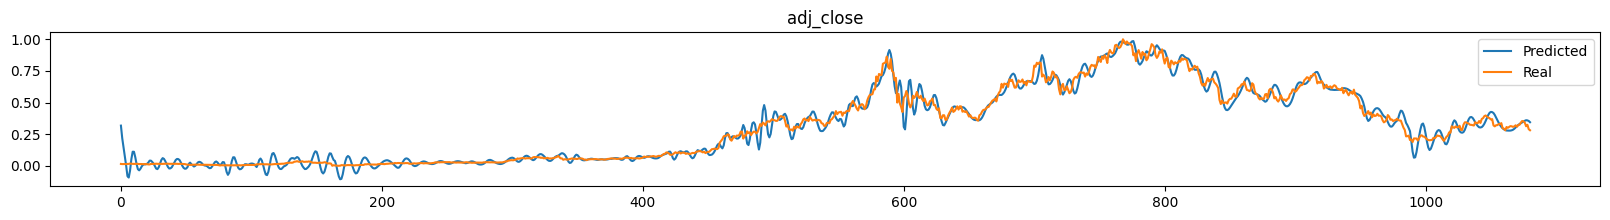

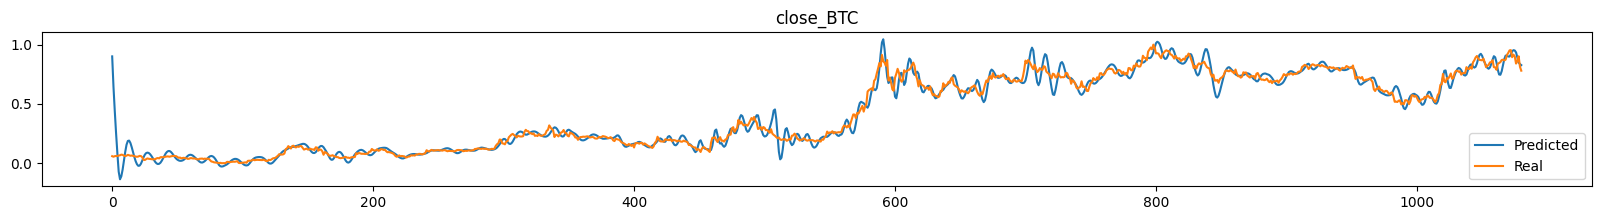

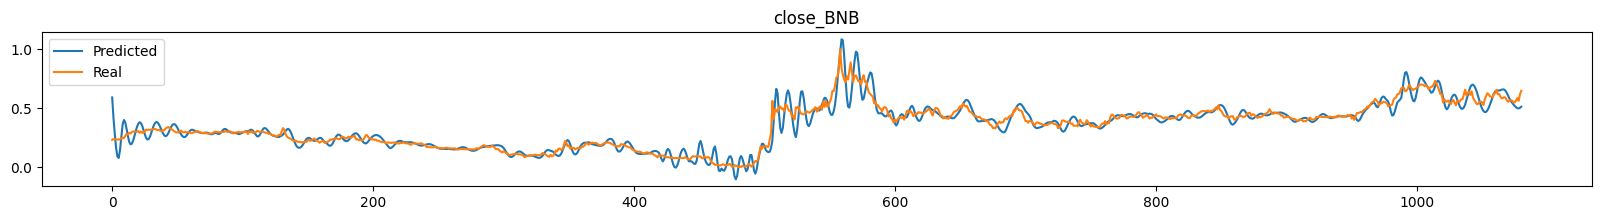

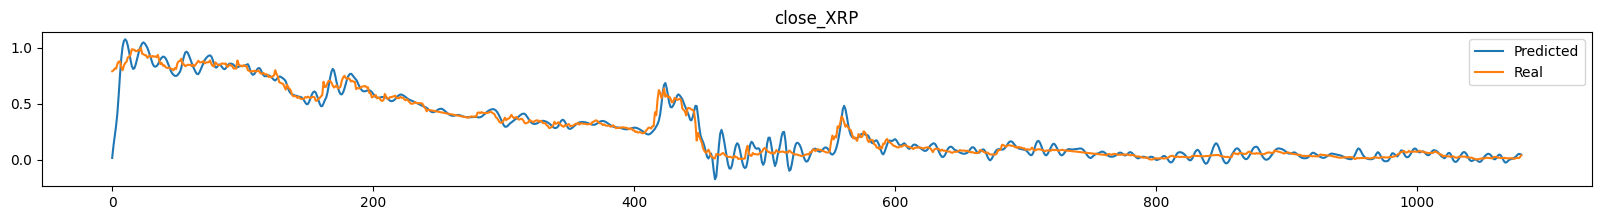

In [91]:
# graph predictions vs actual ALL
for i in range(9):
    if i == 1 or i == 2 or i == 4 or i == 6 or i == 8:
        continue
    plt.figure(figsize=(20,2))
    plt.plot(preds_np[:,i], label='Predicted')
    plt.plot(real_values[:-14,i], label='Real')
    plt.legend()
    plt.title(col_names[i])
    plt.show()

Last month predictions

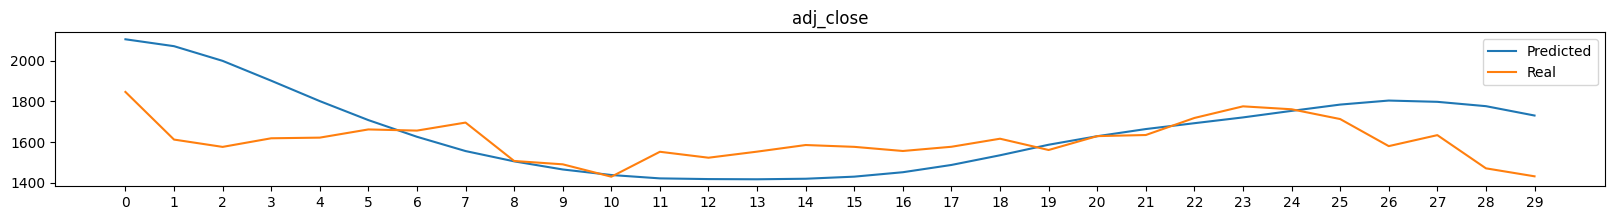

Last 5 predictions: 1784.84433, 1804.63530, 1798.38883, 1777.08041, 1731.09128
Last 5 actual: 1713.76526, 1580.78796, 1634.75500, 1471.69348, 1432.44775


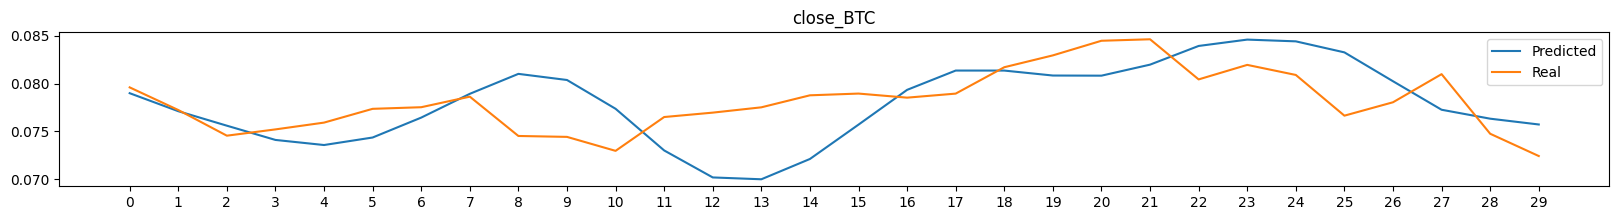

Last 5 predictions: 0.08327, 0.08025, 0.07726, 0.07633, 0.07572
Last 5 actual: 0.07664, 0.07805, 0.08099, 0.07475, 0.07241


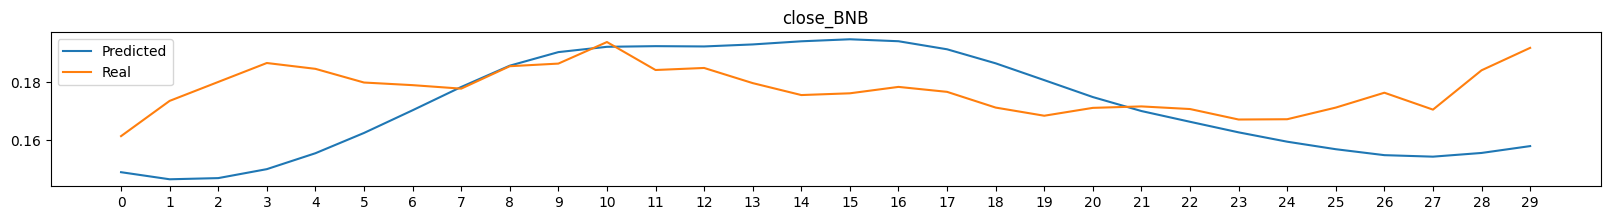

Last 5 predictions: 0.15691, 0.15487, 0.15435, 0.15562, 0.15798
Last 5 actual: 0.17120, 0.17630, 0.17050, 0.18400, 0.19170


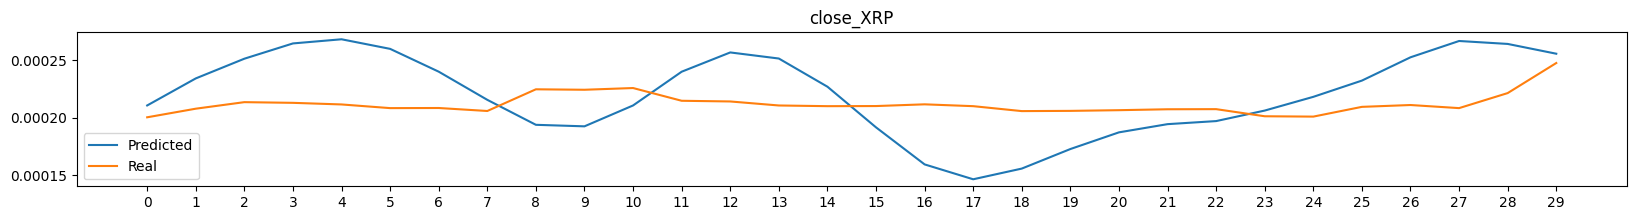

Last 5 predictions: 0.00023, 0.00025, 0.00027, 0.00026, 0.00026
Last 5 actual: 0.00021, 0.00021, 0.00021, 0.00022, 0.00025


In [92]:
# graph predictions vs actual last month
for i in range(9):
    if i == 1 or i == 2 or i == 4 or i == 6 or i == 8:
        continue
    plt.figure(figsize=(20,2))
    plt.plot(preds_np_un[-30:,i], label='Predicted')
    plt.plot(real_values_un[-44:-14,i], label='Real')
    plt.legend()
    plt.xticks(np.arange(0, 30, 1))
    plt.title(col_names[i])
    plt.show()
    print ('Last 5 predictions: %.5f, %.5f, %.5f, %.5f, %.5f' % (preds_np_un[-5,i], preds_np_un[-4,i], preds_np_un[-3,i], preds_np_un[-2,i], preds_np_un[-1,i]))
    print ('Last 5 actual: %.5f, %.5f, %.5f, %.5f, %.5f' % (real_values_un[-19,i], real_values_un[-18,i], real_values_un[-17,i], real_values_un[-16,i], real_values_un[-15,i]))

Last Month Predictions + 2 Week Forecast

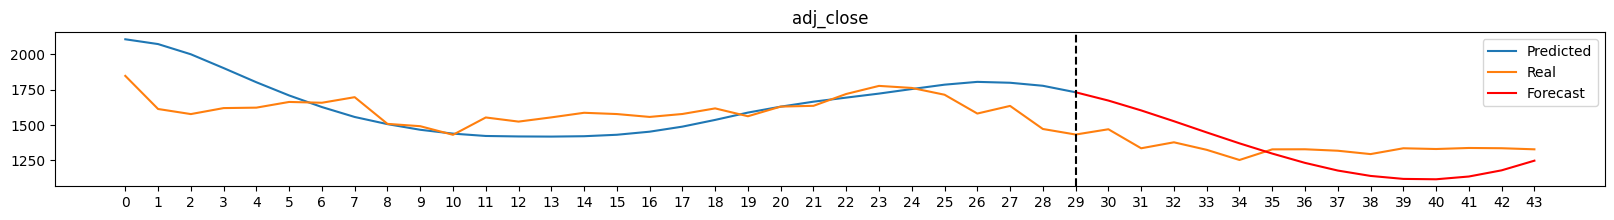

Last prediction (in training): 1731.09128
Start: 1731.09128, First week Forecast: 1672.53621, 1602.89104, 1526.54346, 1447.37929, 1370.18765, 1297.88576, 1232.09844
Start: 1432.44775, First week Real:     1469.74170, 1335.32910, 1377.54138, 1324.38818, 1252.60779, 1327.68018, 1328.25952
Start Difference: 298.64353

Next Day Forecast Difference to Real Value: 202.79452
Next Day Difference in Standard Deviations: 0.15163
Next Day Forecast:   DOWN -58.55507
Next Day Real:       UP   37.29394

First Week Forecast Difference to Real Value: -96.16108
First Week Difference in Standard Deviations: -0.07190
First Week Forecast: DOWN -498.99284
First Week Real:     DOWN -104.18823

Two Week Forecast:   DOWN -483.40665
Two Week Real:       DOWN -104.46912


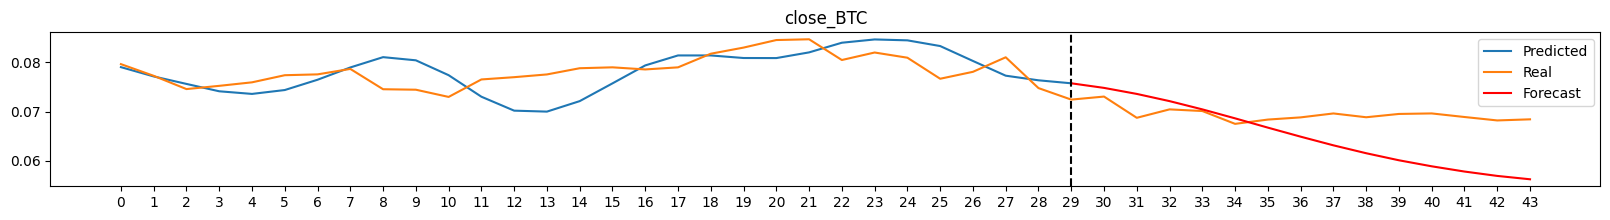

Last prediction (in training): 0.07572
Start: 0.07572, First week Forecast: 0.07479, 0.07357, 0.07210, 0.07043, 0.06861, 0.06673, 0.06490
Start: 0.07241, First week Real:     0.07303, 0.06872, 0.07043, 0.07010, 0.06749, 0.06836, 0.06881
Start Difference: 0.00331

Next Day Forecast Difference to Real Value: 0.00176
Next Day Difference in Standard Deviations: 0.07993
Next Day Forecast:   DOWN -0.00093
Next Day Real:       UP   0.00061

First Week Forecast Difference to Real Value: -0.00391
First Week Difference in Standard Deviations: -0.17759
First Week Forecast: DOWN -0.01082
First Week Real:     DOWN -0.00361

Two Week Forecast:   DOWN -0.01946
Two Week Real:       DOWN -0.00400


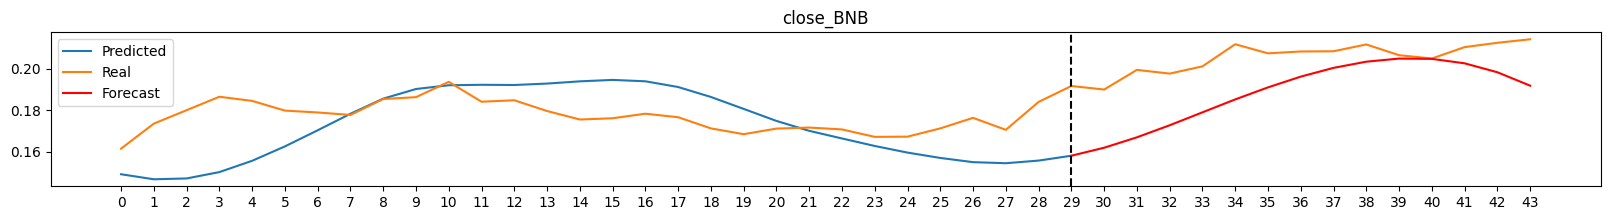

Last prediction (in training): 0.15798
Start: 0.15798, First week Forecast: 0.16184, 0.16688, 0.17271, 0.17896, 0.18521, 0.19103, 0.19624
Start: 0.19170, First week Real:     0.19000, 0.19950, 0.19770, 0.20120, 0.21190, 0.20750, 0.20840
Start Difference: -0.03372

Next Day Forecast Difference to Real Value: -0.02816
Next Day Difference in Standard Deviations: -0.62858
Next Day Forecast:   UP   0.00387
Next Day Real:       DOWN -0.00170

First Week Forecast Difference to Real Value: -0.01216
First Week Difference in Standard Deviations: -0.27149
First Week Forecast: UP   0.03826
First Week Real:     UP   0.01670

Two Week Forecast:   UP   0.03388
Two Week Real:       UP   0.02260


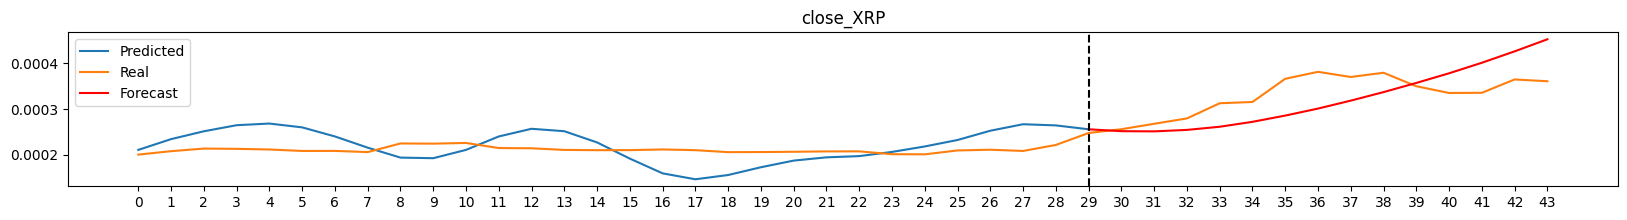

Last prediction (in training): 0.00026
Start: 0.00026, First week Forecast: 0.00025, 0.00025, 0.00025, 0.00026, 0.00027, 0.00029, 0.00030
Start: 0.00025, First week Real:     0.00026, 0.00027, 0.00028, 0.00031, 0.00032, 0.00037, 0.00038
Start Difference: 0.00001

Next Day Forecast Difference to Real Value: -0.00000
Next Day Difference in Standard Deviations: -0.00982
Next Day Forecast:   DOWN -0.00000
Next Day Real:       UP   0.00001

First Week Forecast Difference to Real Value: -0.00008
First Week Difference in Standard Deviations: -0.18422
First Week Forecast: UP   0.00005
First Week Real:     UP   0.00013

Two Week Forecast:   UP   0.00020
Two Week Real:       UP   0.00011


In [93]:
# graph actual vs predictions + forecast
# last 30 days + 7
for i in range(9):
    if i == 1 or i == 2 or i == 4 or i == 6 or i == 8:
        continue
    plt.figure(figsize=(20,2))
    plt.plot(preds_np_un[-30:,i], label='Predicted')
    plt.plot(real_values_un[-44:,i], label='Real')
    plt.plot(np.arange(29,44), forecast_np_un[:,i], label='Forecast', color="red")
    plt.axvline(x=29, color='black', linestyle='--')
    plt.legend()
    plt.xticks(np.arange(0, 44, 1.0))
    plt.title(col_names[i])
    plt.show()
    print ('Last prediction (in training): %.5f' % preds_np_un[-1,i])
    print ('Start: %.5f, First week Forecast: %.5f, %.5f, %.5f, %.5f, %.5f, %.5f, %.5f' % (forecast_np_un[0,i], forecast_np_un[1,i], forecast_np_un[2,i], forecast_np_un[3,i], forecast_np_un[4,i], forecast_np_un[5,i], forecast_np_un[6,i], forecast_np_un[7,i]))
    print ('Start: %.5f, First week Real:     %.5f, %.5f, %.5f, %.5f, %.5f, %.5f, %.5f' % (real_values_un[-15,i], real_values_un[-14,i], real_values_un[-13,i], real_values_un[-12,i], real_values_un[-11,i], real_values_un[-10,i], real_values_un[-9,i], real_values_un[-8,i]))
    print ('Start Difference: %.5f' % (forecast_np_un[0,i] - real_values_un[-15,i]))
    print('')
    print ('Next Day Forecast Difference to Real Value: %.5f' % (forecast_np_un[1,i] - real_values_un[-14,i]))
    print ('Next Day Difference in Standard Deviations: %.5f' % ((forecast_np_un[1,i] - real_values_un[-14,i])/stds[i]))
    if forecast_np_un[0,i] < forecast_np_un[1,i]:
        print("Next Day Forecast:   UP   %.5f" % (forecast_np_un[1,i] - forecast_np_un[0,i]))
    elif forecast_np_un[0,i] > forecast_np_un[1,i]:
        print("Next Day Forecast:   DOWN %.5f" % (forecast_np_un[1,i] - forecast_np_un[0,i]))
    else:
        print("Next Day Forecast:   SAME 0.0")
    if real_values_un[-15,i] < real_values_un[-14,i]:
        print('Next Day Real:       UP   %.5f' % (real_values_un[-14,i] - real_values_un[-15,i]))
    elif real_values_un[-15,i] > real_values_un[-14,i]:
        print("Next Day Real:       DOWN %.5f" % (real_values_un[-14,i] - real_values_un[-15,i]))
    else:
        print("Next Day Real:       SAME 0.0")
    print('')
    print ('First Week Forecast Difference to Real Value: %.5f' % (forecast_np_un[7,i] - real_values_un[-8,i]))
    print ('First Week Difference in Standard Deviations: %.5f' % ((forecast_np_un[7,i] - real_values_un[-8,i])/stds[i]))
    if forecast_np_un[0,i] < forecast_np_un[7,i]:
        print("First Week Forecast: UP   %.5f" % (forecast_np_un[7,i] - forecast_np_un[0,i]))
    elif forecast_np_un[0,i] > forecast_np_un[7,i]:
        print("First Week Forecast: DOWN %.5f" % (forecast_np_un[7,i] - forecast_np_un[0,i]))
    else:
        print("First Week Forecast: SAME 0.0")
    if real_values_un[-15,i] < real_values_un[-8,i]:
        print("First Week Real:     UP   %.5f" % (real_values_un[-8,i] - real_values_un[-15,i]))
    elif real_values_un[-15,i] > real_values_un[-8,i]:
        print("First Week Real:     DOWN %.5f" % (real_values_un[-8,i] - real_values_un[-15,i]))
    else:
        print("First Week Real:     SAME 0.0")
    print('')
    if forecast_np_un[0,i] < forecast_np_un[14,i]:
        print("Two Week Forecast:   UP   %.5f" % (forecast_np_un[14,i] - forecast_np_un[0,i]))
    elif forecast_np_un[0,i] > forecast_np_un[14,i]:
        print("Two Week Forecast:   DOWN %.5f" % (forecast_np_un[14,i] - forecast_np_un[0,i]))
    else:
        print("Two Week Forecast:   SAME 0.0")
    if real_values_un[-15,i] < real_values_un[-1,i]:
        print("Two Week Real:       UP   %.5f" % (real_values_un[-1,i] - real_values_un[-15,i]))
    elif real_values_un[-15,i] > real_values_un[-1,i]:
        print("Two Week Real:       DOWN %.5f" % (real_values_un[-1,i] - real_values_un[-15,i]))
    else:
        print("Two Week Real:       SAME 0.0")